# Install required packages

In [33]:
!pip install q gdown cytotrace2-py anndata scanpy pandas

# import packages and suppress irrelevant warnings

In [34]:
import warnings
import logging
import matplotlib

# suppress the Helvetica font
warnings.filterwarnings("ignore", message="findfont: Font family")
# Suppress font-related messages
logging.getLogger('matplotlib.font_manager').setLevel(logging.ERROR)

# Suppress the deprecation warning from cytotrace2_py
warnings.filterwarnings(
    "ignore",
    message="pkg_resources is deprecated as an API.*",
    category=UserWarning,
    module="cytotrace2_py.common.gen_utils"
)

In [35]:
import gdown
import os
import requests
import pandas as pd
from cytotrace2_py.cytotrace2_py import cytotrace2
import matplotlib.pyplot as plt

# Download expression file and annotatin file

In [36]:
os.makedirs("data", exist_ok=True)

output = ["data/Pancreas_10x_downsampled_expression.txt", "data/Pancreas_10x_downsampled_annotation.txt"]
file_ids = ["11eI1gSBoBqn9ccvBbthZ2nPW3CENsKbT", "1UESeZJDl2qWYnSu0VQQA5igpEbtxZPgq"]
for f_id in file_ids:
    url = f"https://drive.google.com/uc?id={file_id[f_id]}"
    # Download only if the file doesn't already exist
    if not os.path.exists(output):
        gdown.download(url, output, quiet=False)
    else:
        print("Dataset already downloaded.")

# What is expression file?

In [37]:
expression = pd.read_csv("data/Pancreas_10x_downsampled_expression.txt", sep='\t')

### Columns = individual cells

* Each column label (e.g. `TCTAATAGGAGCGAG_1_2`) is a **`cellID`**
* These come from the sequencing process (droplet barcodes) — they **identify individual cells**, not **cell types**
* So `cellID ≠ cell type`
* The corresponding **cell type or "phenotype"** must come from a **separate annotation file**

---

### Rows = individual genes

* Each row is a gene symbol (e.g., `Xkr4`, `Rp1`, `Gm1992`)

---

### Values = expression levels

* The values are typically raw counts or normalized values (Counts Per Million)
  * e.g., how many times mRNA for `Xkr4` was detected in that cell
* A `0` means no expression for that gene in that cell
* A `10`, `500`, etc. means that gene was transcribed that many times (or normalized to that magnitude)

---

### Summary:

| Axis        | What it represents                             |
| ----------- | ---------------------------------------------- |
| Columns     | Individual **cells** (identified by barcode)   |
| Rows        | Individual **genes** (symbols like `Xkr4`)     |
| Cell values | Expression level (e.g. count or CPM)           |
| Cell type   | Not in this matrix — stored in annotation file |

# What is the annotation file?

In [39]:
annotation = pd.read_csv("data/Pancreas_10x_downsampled_annotation.txt", sep='\t')

In [40]:
annotation.head()

,phenotype
CTCTAATAGGAGCGAG_1_2,Alpha cell
ACGATACTCGCGCCAA_1_3,Alpha cell
GTGTTAGTCCACTGGG_1_2,Alpha cell
CGAGAAGTCGTTACAG_1_3,Alpha cell
TGGCTGGTCATGTCCC_1_2,Alpha cell


The first column are indicies of **cellID** and the second column is **phenotype**

> In single-cell RNA-seq, you're measuring **gene expression in thousands (or millions) of individual cells**, so each cell **must have a unique identifier** — that's what the `cellID` is for.


### Why `cellID` is essential:

1. **Each row of expression data = one cell**

   * You're working with a matrix: **cells × genes**
   * So you need a unique `cellID` to know which expression profile belongs to which cell

2. **No pre-existing IDs in the body**

   * Your body doesn't label cells with barcodes
   * So the sequencing pipeline assigns artificial IDs during the experiment

3. **You need it to match annotations**

   * If you cluster cells (e.g., by expression), or label them by type (like "Epsilon cell"), those labels must be linked to **specific cells** using their `cellID`


### What it looks like in practice:

| `cellID`               | `gene1` | `gene2` | ... | `phenotype`             |
| ---------------------- | ------- | ------- | --- | ----------------------- |
| `GGTATTGAGTCGTACT_1_0` | 5       | 0       | ... | Epsilon cell            |
| `GTAACTGGTCACTGGC_1_3` | 0       | 8       | ... | Immature endocrine cell |

* `cellID` lets you join expression data and annotation
* Without `cellID`, you’d have no way to say **which cell is which**


In [41]:
# list all possbile cell type
annotation['phenotype'].unique()

array(['Alpha cell', 'Beta cell', 'Delta cell',
       'Endocrine committed precursor cell', 'Endocrine progenitor',
       'Epsilon cell', 'Immature endocrine cell',
       'Multipotent pancreatic progenitor'], dtype=object)

## What are these "phenotype" e.g. Alpha, Beta, Epsilon, and Endocrine Precursor Cells?

These are all **cell types** found in the **pancreas**, specifically in the islets of Langerhans, a region involved in hormone production (like insulin and glucagon).

They’re biologically distinct cell types, each with a specific function, and each with a unique gene expression signature that allows us to identify them in single-cell RNA-seq data.

> A cell type is defined by the set of genes it expresses, especially marker genes that are unique or highly active in that type.

* These phenotype labels were assigned based on the clustering of gene expression profiles using marker genes.
  
> Clustering + marker gene expression $\rightarrow$ label = Alpha, Beta, etc.

* Each type expresses specific marker genes. For example:

  * Beta cells: INS (insulin)
  * Alpha cells: GCG (glucagon)
  * Epsilon cells: GHRL (ghrelin)
  * Precursor cells: lower or mixed expression of these markers

* Same cell type means similar overall gene expression profile. But there is still some natural variability:
    - Due to the cell cycle
    - Environmental cues
    - Technical noise in the experiment

### How was this likely done?

1. The original expression matrix was clustered (e.g., with Louvain or Leiden)
2. For each cluster, marker genes were checked:

   * If cells express `INS`, they’re Beta
   * If they express `GCG`, they’re Alpha
   * If they express none or some, they are likely not yet fully differentiated and are labeled as precursors or immature.
3. The label was saved as `phenotype`


# To find the cell type of a column:

In [42]:
# assuming you have expression (genes × cells) and annotation (cellID → phenotype)
# example: look up cell type for one column
cell_id = "CTCTAATAGGAGCGAG_1_2"
annotation.loc[cell_id]

phenotype    Alpha cell
Name: CTCTAATAGGAGCGAG_1_2, dtype: object

# Run Cytotrace2

In [43]:
plt.rcParams['font.family'] = 'DejaVu Sans' # Use a generic font

cytotrace2: Input parameters
    Input file: data/Pancreas_10x_downsampled_expression.txt
    Species: mouse
    Parallelization enabled: True
    Batch size: 20000
    Smoothing batch size: 1000
    Seed: 14
    Output directory: cytotrace2_results
    Plotting enabled: True
    Verbose mode enabled: True
    User-provided limit for number of cores to use: None
       ...8 cores detected. CytoTRACE 2 will run using up to 4/8 cores.
cytotrace2: Loading dataset
cytotrace2: Dataset characteristics
    Number of input genes:  27998
    Number of input cells:  2850
cytotrace2: Checking models...
All model files are present.
cytotrace2: Computing UMAP embeddings from full expression
cytotrace2: The passed batch_size is greater than the number of cells in the subsample. 
    Now setting batch_size to 2850.
cytotrace2: Preprocessing
cytotrace2: Running 1 prediction batch(es) sequentially using 4 cores per batch.
cytotrace2: Initiated processing batch 1/1 with 2850 cells
    14247 input genes 

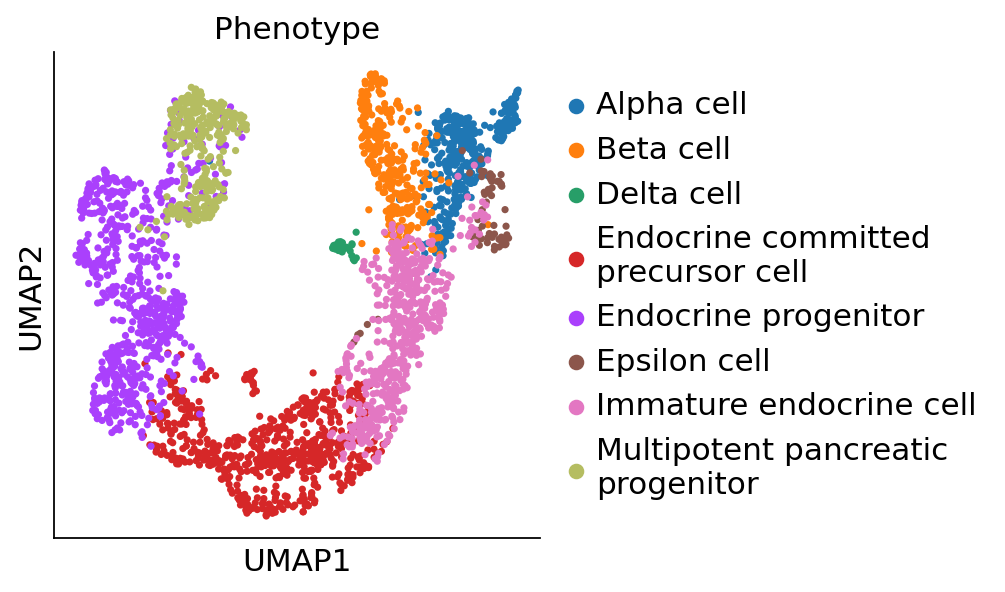

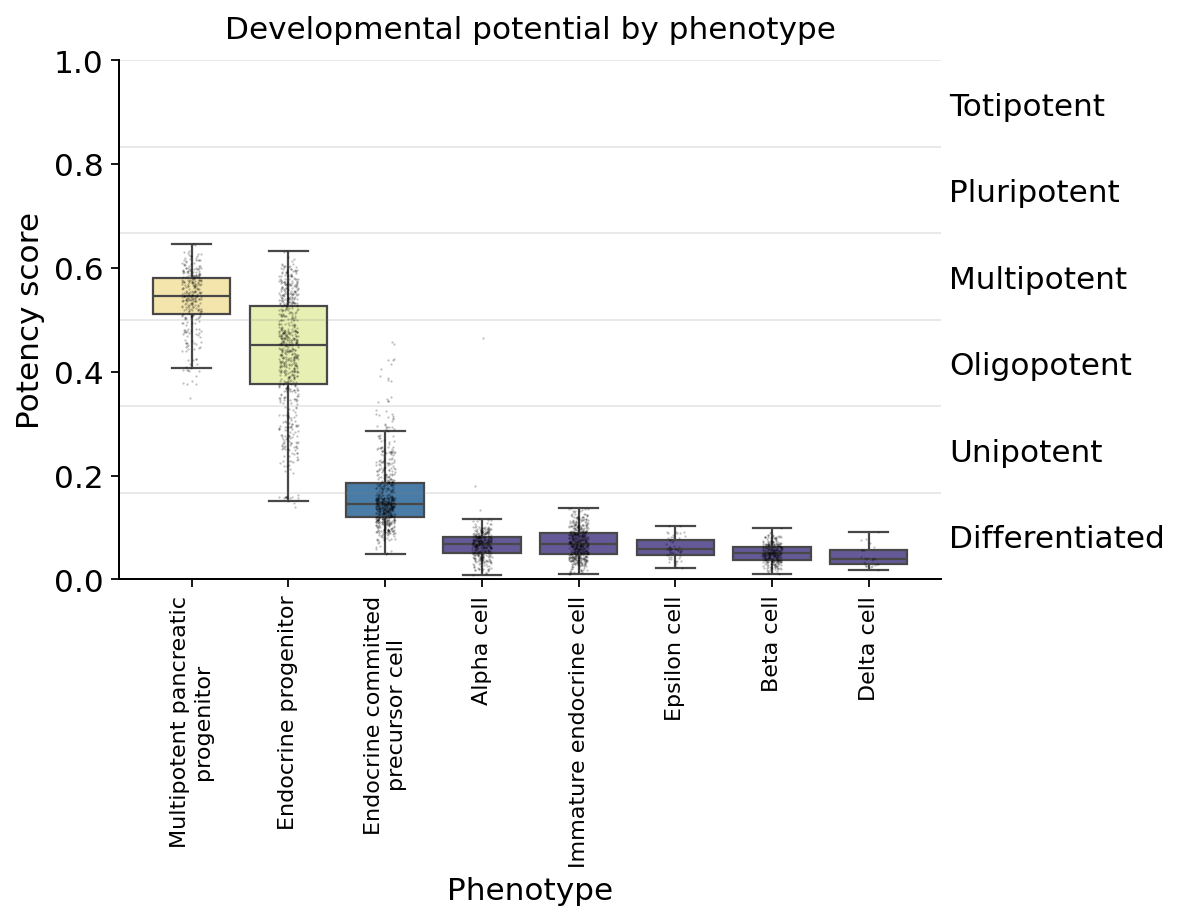

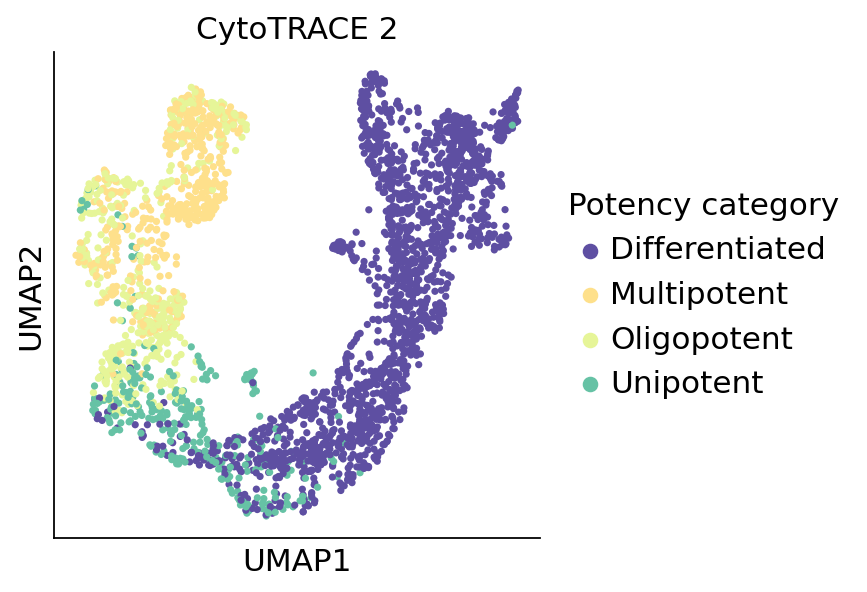

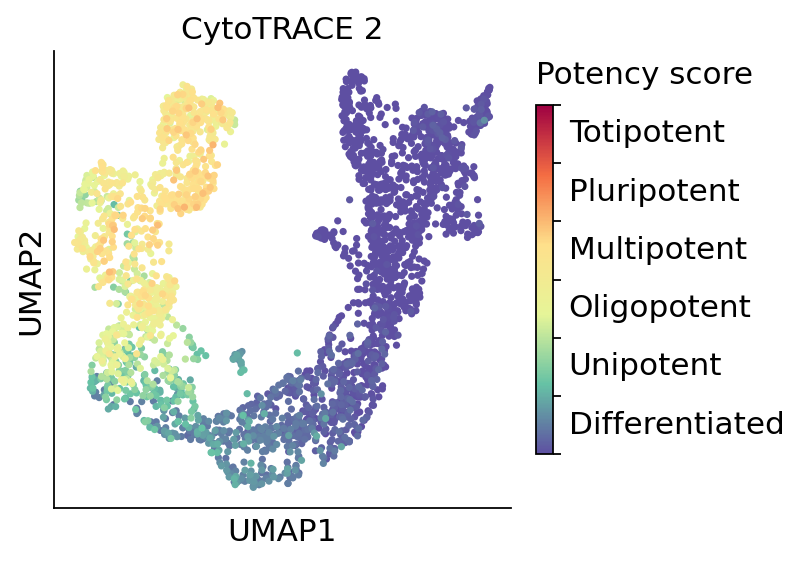

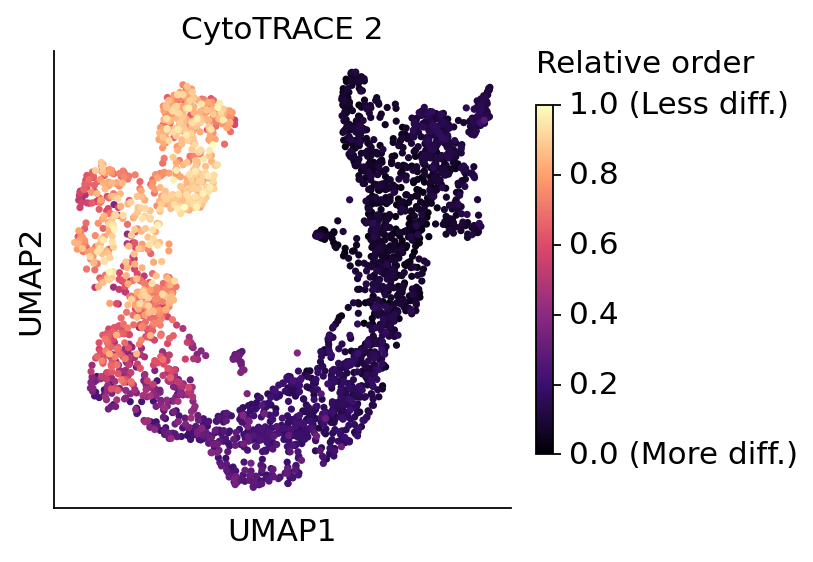

In [44]:
from cytotrace2_py.cytotrace2_py import *

results =  cytotrace2("data/Pancreas_10x_downsampled_expression.txt",
                      annotation_path="data/Pancreas_10x_downsampled_annotation.txt",
                      species="mouse")